# Building Noise Models

## T1 Time (qubit lifetime) and T2 Time (qubit dephasing time)

The fidelity of a real qubit is usually evaluate by two metrics: T1 Time (qubit lifetime) and T2 Time (qubit dephasing time).
T1 and T2 time are effectively two different ways to look at the same question: how long do the qubits stay useful for computation? T1 is concerned with qubit lifetime, asking how long you can tell the $|1\rangle$ state from the $|0\rangle$ state, while T2 asking how long you can tell the $+\rangle$ state from the $|-\rangle$ state

Suppose a qubit is initialized with state $|1\rangle$. Probability that a qubit will stay in state $|1\rangle$ after time $t$ is given by formula
$$
P(|1\rangle) = e^{-\frac{t}{T_1}}
$$

Similarly for T2.

## Introduction

This notebook introduces how to use the Qiskit Aer `noise` module to build custom noise models for noisy simulations.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, 
    pauli_error, depolarizing_error, thermal_relaxation_error)

## Qiskit Aer Noise Module

The Qiskit Aer `noise` module contains Python classes to build customized noise models for simulation. There are three key classes:

1. The `NoiseModel` class which stores a noise model used for noisy simulation.
2. The `QuantumError` class which describes CPTP gate errors. These can be applied:
    * After *gate* or *reset* instructions
    * Before *measure* instructions.

3. The `ReadoutError` class which describes classical readout errors.

## Quantum Errors

Rather than deal with the `QuantumError` object directly, many helper functions exist to automatically generate a specific type of parameterized quantum error. These are contained in the `noise` module and include functions for many common errors types used in quantum computing research. The function names and the type of error they return are:

| Standard error function | Details |
| --- | --- |
| `kraus_error` | a general n-qubit CPTP error channel given as a list of Kraus matrices $[K_0, ...]$. |
| `mixed_unitary_error` | an n-qubit mixed unitary error given as a list of unitary matrices and probabilities $[(U_0, p_0),...]$. |
| `coherent_unitary_error` | an n-qubit coherent unitary error given as a single unitary matrix $U$. |
| `pauli_error` | an n-qubit Pauli error channel (mixed unitary) given as a list of Pauli's and probabilities $[(P_0, p_0),...]$ |
| `depolarizing_error` | an n-qubit depolarizing error channel parameterized by a depolarization probability $p$. |
| `reset_error` | a single-qubit reset error parameterized by a probabilities $p_0, p_1$ of resetting to the $|0\rangle$, $|1\rangle$ state.|
| `thermal_relaxation_error` | a single qubit thermal relaxation channel parameterized by relaxation time constants $T_1$, $T_2$, gate time $t$, and excited state thermal population $p_1$. |
| `phase_amplitude_damping_error` | A single-qubit generalized combined phase and amplitude damping error channel given by an amplitude damping parameter $\lambda$, a phase damping parameter $\gamma$, and an excited state thermal population $p_1$. |
| `amplitude_damping_error` |  A single-qubit generalized amplitude damping error channel given by an amplitude damping parameter $\lambda$, and an excited state thermal population $p_1$. |
| `phase_damping_error` |  A single-qubit phase damping error channel given by a phase damping parameter $\gamma$ |

### Combining quantum errors

`QuantumError` instances can be combined by using composition, tensor product, and tensor expansion (reversed order tensor product) to produce new `QuantumErrors` as:

 * Composition: $\cal{E}(\rho)=\cal{E_2}(\cal{E_1}(\rho))$ as `error = error1.compose(error2)`
 * Tensor product: $\cal{E}(\rho) =(\cal{E_1}\otimes\cal{E_2})(\rho)$ as `error error1.tensor(error2)`
 * Expand product: $\cal{E}(\rho) =(\cal{E_2}\otimes\cal{E_1})(\rho)$ as `error error1.expand(error2)`

### Example

For example to construct a 5% single-qubit Bit-flip error:

In [3]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [4]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


In [5]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


### Converting to and from QuantumChannel operators
 
We can also convert back and forth between `QuantumError` objects in Qiskit Aer and `QuantumChannel` objects in Qiskit Terra.

In [6]:
# Convert to Kraus operator
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [-1.20234617e-16+0.j,  9.74679434e-01+0.j]],

       [[ 2.62045272e-16+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -2.84112242e-16+0.j]]],
      input_dims=(2,), output_dims=(2,))


In [7]:
# Convert to Superoperator
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]],
        input_dims=(2,), output_dims=(2,))


In [8]:
# Convert back to a quantum error
print(QuantumError(bit_flip_kraus))

# Check conversion is equivalent to original error
QuantumError(bit_flip_kraus) == bit_flip

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


True

### Readout Error

Classical readout errors are specified by a list of assignment probabilities vectors $P(A|B)$:

  * $A$ is the *recorded* classical bit value
  * $B$ is the *true* bit value returned from the measurement 
 
E.g. for 1 qubits: $ P(A|B) = [P(A|0), P(A|1)]$.

In [10]:
# Measurement miss-assignement probabilities
p0given1 = 0.1
p1given0 = 0.05

ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

ReadoutError([[0.95 0.05]
 [0.1  0.9 ]])

Readout errors may also be combined using `compose`, `tensor` and `expand` like with quantum errors.

## Adding errors to a Noise Model

When adding a quantum error to a noise model we must specify the type of *instruction* that it acts on, and what qubits to apply it to. There are two cases for Quantum Errors:
 
 1. All-qubit quantum error
 2. Specific qubit quantum error
  
### 1. All-qubit quantum error

This applies the same error to any occurrence of an instruction, regardless of which qubits it acts on.

It is added as `noise_model.add_all_qubit_quantum_error(error, instructions)`:

In [9]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3']


### 2. Specific qubit quantum error

This applies the error to any occurrence of an instruction acting on a specified list of qubits. Note that the order of the qubit matters: For a 2-qubit gate an error applied to qubits [0, 1] is different to one applied to qubits [1, 0] for example.

It is added as `noise_model.add_quantum_error(error, instructions, qubits)`:

In [10]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'u3']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', (0,)), ('u2', (0,)), ('u3', (0,))]


### Note on non-local qubit quantum error

`NoiseModel` does not support addition of non-local qubit quantum errors. They should be handled outside of `NoiseModel`. That suggests you should write your own transpiler pass (`TransformationPass`) and run the pass just before running the simulator if you need to insert your quantum errors into your circuit under your own conditions. See `noise.passes.LocalNoisePass` for example of how to implement such a transpiler pass.

### Executing a noisy simulation with a noise model

The command `AerSimulator(noise_model=noise_model)` returns a simulator configured to the given noise model. In addition to setting the simulator's noise model, it also overrides the simulator's basis gates, according to the gates of the noise model.

## Noise Model Examples

We will now give some examples of noise models. For our demonstrations we will use a simple test circuit generating a n-qubit GHZ state:

In [11]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


### Ideal Simulation

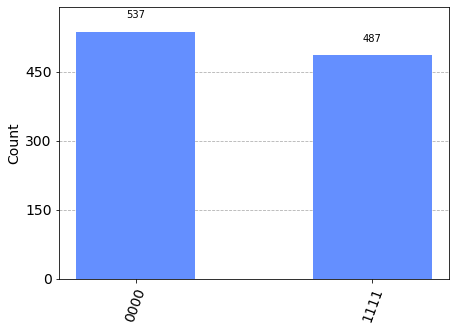

In [12]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

## Noise Example 1: Basic bit-flip error noise model

Lets consider a simple toy noise model example common in quantum information theory research:

* When applying a single qubit gate, flip the state of the qubit with probability `p_gate1`.
* When applying a 2-qubit gate apply single-qubit errors to each qubit.
* When resetting a qubit reset to 1 instead of 0 with probability `p_reset`.
* When measuring a qubit, flip the state of the qubit with probability `p_meas`.

In [13]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['reset', 'u2', 'u3', 'u1', 'cx', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


### Executing the noisy simulation

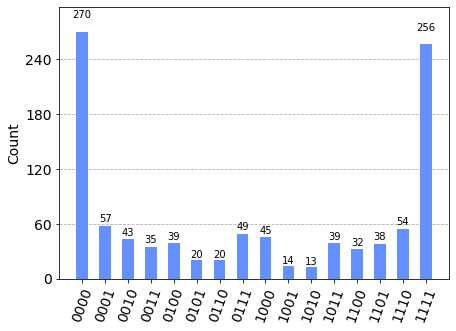

In [17]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

## Example 2: T1/T2 thermal relaxation

Now consider a more realistic error model based on thermal relaxation with the qubit environment:
* Each qubit is parameterized by a thermal relaxation time constant $T_1$ and a dephasing time constant $T_2$.
* Note that we must have $T_2 \le 2 T_1$.
* Error rates on instructions are determined by gate times and qubit $T_1$, $T_2$ values.

In [15]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['reset', 'u2', 'u3', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


### Executing the noisy simulation

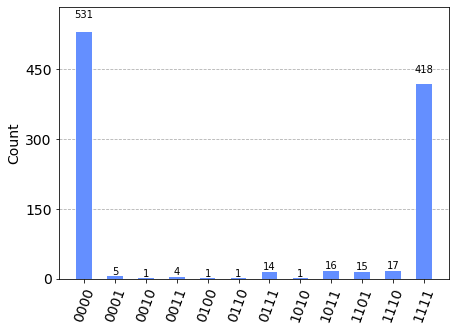

In [16]:
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

## Introduction

This notebook shows how to add custom unitary gates to a quantum circuit, and use them for noise simulations in Qiskit Aer.

In [19]:
from qiskit import transpile, QuantumCircuit
import qiskit.quantum_info as qi

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error

from qiskit.tools.visualization import plot_histogram

## Creating matrix operators

We can use the `Operator` class in `qiskit.quantum_info` to represent arbitrary matrix operators. If the operator is unitary it can then be added to a quantum circuit and used for simulation on Qiskit Aer.

Lets create two operators below for a CNOT gate and an iSWAP gate:

$$
\text{CNOT} = \left(\begin{matrix} 
1 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 1 \\ 
0 & 0 & 1 & 0 \\ 
0 & 1 & 0 & 0
\end{matrix}\right), \quad
\text{iSWAP} = \left(\begin{matrix} 
1 & 0 & 0 & 0 \\ 
0 & 0 & i & 0 \\ 
0 & i & 0 & 0 \\ 
0 & 0 & 0 & 1
\end{matrix}\right)
$$


In [20]:
# CNOT matrix operator with qubit-0 as control and qubit-1 as target
cx_op = qi.Operator([[1, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

# iSWAP matrix operator
iswap_op = qi.Operator([[1, 0, 0, 0],
                        [0, 0, 1j, 0],
                        [0, 1j, 0, 0],
                        [0, 0, 0, 1]])

**Note:** The matrix is specified with respect to the tensor product $U_{b}\otimes U_{a}$ for qubits specified by list `[a, b]`.
## Using operators in circuits

Let us demonstrate how these can be used in a circuit. We will consider an example of implementing a CNOT gate decomposed in terms of single-qubit gates and the iSWAP gate as follows.

In [21]:
# CNOT in terms of iSWAP and single-qubit gates
cx_circ = QuantumCircuit(2, name='cx<iSWAP>')

# Add gates
cx_circ.sdg(1)
cx_circ.h(1)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.sdg(0)
cx_circ.h(0)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.s(1)

print(cx_circ)

     ┌─────┐     ┌────────┐┌─────┐┌───┐┌─────┐┌────────┐     
q_0: ┤ Sdg ├─────┤0       ├┤ Sdg ├┤ H ├┤ Sdg ├┤0       ├─────
     ├─────┤┌───┐│  iswap │└─────┘└───┘└─────┘│  iswap │┌───┐
q_1: ┤ Sdg ├┤ H ├┤1       ├───────────────────┤1       ├┤ S ├
     └─────┘└───┘└────────┘                   └────────┘└───┘


Note that we have assigned an optional *label* of `"iswap"` to the unitary when it is inserted. This allows us to identify this unitary in a Qiskit Aer `NoiseModel` so that we can add errors to these custom unitary gates in noisy circuit simulations.

We can confirm this circuit returns the correct output using the `Operator` class as a simulator for the circuit:

In [22]:
# Simulate the unitary for the circuit using Operator:
unitary = qi.Operator(cx_circ)
print(unitary)

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


And to confirm the output is correct we can compute the average gate fidelity:

In [23]:
f_ave = qi.average_gate_fidelity(cx_op, unitary)
print("Average Gate Fidelity: F = {:f}".format(f_ave))

Average Gate Fidelity: F = 1.000000


## Creating a custom unitary in a noise model

The Qiskit Aer `AerSimulator` supports simulation of arbitrary unitary operators directly as specified by the `"unitary"` in the basis gates.

In [ ]:
'unitary' in AerSimulator().configuration().basis_gates

True

This allows us to add noise models to arbitrary unitaries in our simulation when we identify them using the optional `label` argument of `QuantumCircuit.unitary`.

We will now do this by creating a `NoiseModel` that includes a quantum error channel on our custom iSWAP gate. For our example we will create a 2-qubit error consisting of two single-qubit amplitude damping channels with different damping parameters. For now we will assume all the other circuit instructions are ideal.

In [27]:
# Error parameters
param_q0 = 0.05  # damping parameter for qubit-0
param_q1 = 0.1   # damping parameter for qubit-1

# Construct the error
qerror_q0 = amplitude_damping_error(param_q0)
qerror_q1 = amplitude_damping_error(param_q1)
iswap_error = qerror_q1.tensor(qerror_q0)

# Build the noise model by adding the error to the "iswap" gate
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(iswap_error, 'iswap')

Note that when we add an error to a custom label such as `"iswap"` the `NoiseModel` does not know what gate this label is supposed to apply to, so we must manually add the desired gate string to the noise model `basis_gates`. This ensures that the compiler will unroll to the correct basis gates for the noise model simulation. This can done using the `NoiseModel.add_basis_gates` function:

In [28]:
noise_model.add_basis_gates(['unitary'])
print(noise_model.basis_gates)

['cx', 'id', 'rz', 'sx', 'unitary']


By default the basis gates of a noise model are `['cx','id','u3']` plus any standard `AerSimulator` basis gates that are added to the noise model.

## Simulating a custom unitary noise model

Let us first take our previous CX circuit and add an initial Hadamard gate and final measurement to create a Bell-state preparation circuit that we may simulator on the `AerSimulator` both for the ideal and noisy case:

In [24]:
# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(2, 2, name='bell')
bell_circ.h(0)
bell_circ.append(cx_circ, [0, 1])
bell_circ.measure([0,1], [0,1])
print(bell_circ)

     ┌───┐┌────────────┐┌─┐   
q_0: ┤ H ├┤0           ├┤M├───
     └───┘│  cx<iSWAP> │└╥┘┌─┐
q_1: ─────┤1           ├─╫─┤M├
          └────────────┘ ║ └╥┘
c: 2/════════════════════╩══╩═
                         0  1 


### Ideal output

Let's first see the ideal output. Since this generates a Bell-state we expect two peaks for 00 and 11.

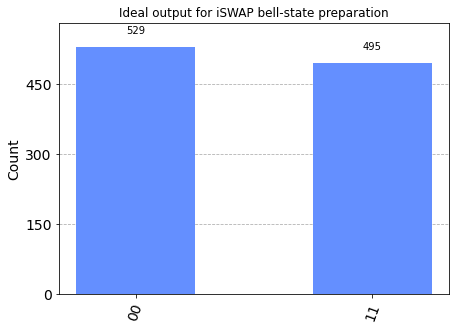

In [29]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
tbell_circ = transpile(bell_circ, sim_ideal)

ideal_result = sim_ideal.run(tbell_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for iSWAP bell-state preparation')

### Noisy circuit execution

Finally, let's now simulate it with our custom noise model. Since there is a small amplitude damping error on the two-qubit gates we expect small additional peaks for the 01 and 10 outcome probabilities.

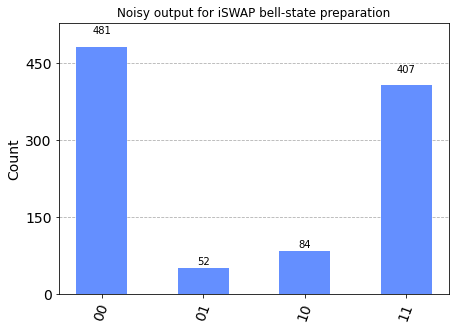

In [30]:
# Create noisy simulator and transpile circuit
sim_noise = AerSimulator(noise_model=noise_model)
tbell_circ_noise = transpile(bell_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(tbell_circ_noise).result()
noise_counts = noise_result.get_counts(bell_circ)
plot_histogram(noise_counts,
               title='Noisy output for iSWAP bell-state preparation')